In [194]:
from tools import load_iris, split_train_test

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal


Section 1:

In [163]:
def gen_data(
    n: int,
    locs: np.ndarray,
    scales: np.ndarray
) -> np.ndarray:
    '''
    Return n data points, their classes and a unique list of all classes, from each normal distributions
    shifted and scaled by the values in locs and scales
    '''
    features = []
    target_class = []
    for i, (loc, scale) in enumerate(zip(locs, scales)):
        # Generate n samples from the normal distribution with the given loc (mean) and scale (SD)
        r = norm.rvs(loc=loc, scale=scale, size=n)
        features.append(r)
        target_class.append(np.full(n, i))  #assign same class label to all generated samples
    features = np.concatenate(features)
    target_class = np.concatenate(target_class)
    classes = np.arange(len(locs))

    # return all 3
    return features, target_class, classes



In [15]:
gen_data(1, [-1, 0, 1], [2, 2, 2])

(array([-1.16800792,  0.71457197,  0.84865952]),
 array([0, 1, 2]),
 array([0, 1, 2]))

In [116]:
gen_data(2, [0, 2], [4, 4])

(array([ 5.13619199, -4.94932987,  8.6511066 ,  4.49299467]),
 array([0, 0, 1, 1]),
 array([0, 1]))

In [164]:
features, targets, classes = gen_data(50, [-1, 1], [np.sqrt(5), np.sqrt(5)])

In [195]:
#print(features, targets)

In [165]:
(train_features, train_targets), (test_features, test_targets)\
    = split_train_test(features, targets, train_ratio=0.8)

Section 2:

In [146]:
def plot_data(data: np.ndarray, labels: np.ndarray):
    '''
    Plot the data points using scatter, colored by their class.
    '''
    plt.figure()
    class_0 = data[labels == 0]
    class_1 = data[labels == 1]

    # Create scatter plot, where the color of each point corresponds to its class label
    plt.scatter(class_0, np.zeros_like(class_0), c='blue', marker='o')
    plt.scatter(class_1, np.zeros_like(class_1), c= 'orange', marker = 'x')
    plt.savefig('2_1.png')

    # Display the plot
    plt.show()


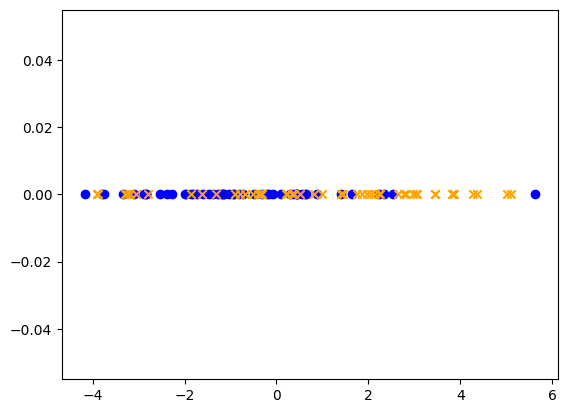

In [166]:
%matplotlib inline
plot_data(features, targets)


Section 3:

In [184]:
def mean_of_class(
    features: np.ndarray,
    targets: np.ndarray,
    selected_class: int
) -> np.ndarray:
    '''
    Estimate the mean of a selected class given all features
    and targets in a dataset
    '''
    #data = []
    #for feature, target in zip(features, targets):
    #    if target == selected_class:
    #        data.append(feature)
    #return np.mean(data)
    
    # Filter the features where the target matches the selected class
    class_features = features[targets == selected_class]

    # If no samples belong to the selected class
    if class_features.shape[0] == 0:
        return np.nan  # missing data
    
    # Compute the mean of the selected class
    return np.mean(class_features, axis=0)


In [185]:
mean_of_class(train_features, train_targets, 0)

np.float64(-0.5147130539618271)

Section 4:

In [124]:
def estimate_covariance():
    values = np.array([
        [0.30, 8.60],
        [0.20, 5.60],
        [0.15, 2.30],
        [0.35, 9.90],
        [0.05, 0.10],
    ])
    # 'It seems like these values are correlated, lets plot.
    plt.scatter(values[:, 0], values[:, 1])
    plt.show()
    # We can see from the plot that the values are indeed
    # somewhat correlated. Lets print the covariance matrix
    print(np.cov(values, rowvar=False))
    # The values that are off the diagonal axis are covariances
    # of each pair of variables in our data. A higher value
    # means that the variables are more correlated
    values = np.array([
        [0.30, 8.60],
        [0.20, 5.60],
        [5.15, 9.30],
        [0.35, 4.90],
        [9.05, 0.10],
    ])
    # These variables don't seem that correlated. Lets plot again.
    plt.scatter(values[:, 0], values[:, 1])
    plt.show()
    # The values are all over the place! Lets print the covariance
    # matrix
    print(np.cov(values, rowvar=False))
    # We are right again. The off-diagonal values are way lower now,
    # meaning that the variables are less correlated.

#estimate_covariance()

In [186]:
def covar_of_class(
    features: np.ndarray,
    targets: np.ndarray,
    selected_class: int
) -> np.ndarray:
    '''
    Estimate the covariance of a selected class given all
    features and targets in a dataset
    '''
    # Filter the features where the target matches the selected class
    class_features = features[targets == selected_class]

    # If no samples belong to the selected class
    if class_features.shape[0] < 2:
        return np.nan  # missing data
    
    # Compute the mean of the selected class
    return np.cov(class_features, rowvar=False)

In [187]:
covar_of_class(train_features, train_targets, 0)

array(3.50766881)

Section 5:

In [189]:
def likelihood_of_class(
    feature: np.ndarray,
    class_mean: np.ndarray,
    class_covar: np.ndarray
) -> float:
    '''
    Estimate the likelihood that a sample is drawn
    from a multivariate normal distribution, given the mean
    and covariance of the distribution.
    '''
    if feature.ndim == 1:
        # Univariate normal distribution
        return norm.pdf(feature, loc=class_mean, scale=np.sqrt(class_covar))
    
    # Multidimensional case (multivariate normal distribution)
    return multivariate_normal.pdf(feature, mean=class_mean, cov=class_covar)



In [190]:
class_mean = mean_of_class(train_features, train_targets, 0)
class_cov = covar_of_class(train_features, train_targets, 0)

In [191]:
likelihood_of_class(test_features[0:3], class_mean, class_cov)

array([0.04587101, 0.03149658, 0.0828333 ])

Section 6: 

In [192]:
def maximum_likelihood(
    train_features: np.ndarray,
    train_targets: np.ndarray,
    test_features: np.ndarray,
    classes: list
) -> np.ndarray:
    '''
    Calculate the maximum likelihood for each test point in
    test_features by first estimating the mean and covariance
    of all classes over the training set.

    You should return
    a [test_features.shape[0] x len(classes)] shaped numpy
    array
    '''
    means, covs = [], []
    for class_label in classes:
        class_mean = mean_of_class(train_features, train_targets, class_label)
        means.append(class_mean)
        class_cov = covar_of_class(train_features, train_targets, class_label)
        covs.append(class_cov)
    likelihoods = np.zeros((test_features.shape[0], len(classes)))
    for i in range(test_features.shape[0]):
        for j, (mean, cov) in enumerate(zip(means, covs)):
            likelihoods[i,j] = likelihood_of_class(test_features[i], mean, cov)
    return np.array(likelihoods)


In [193]:
maximum_likelihood(train_features, train_targets, test_features, classes)

array([[0.04587101, 0.02641078],
       [0.03149658, 0.01959421],
       [0.0828333 , 0.14439926],
       [0.21212474, 0.12843641],
       [0.17639133, 0.15781572],
       [0.18659039, 0.15589498],
       [0.16575864, 0.15884219],
       [0.1020616 , 0.05225346],
       [0.08217091, 0.04303305],
       [0.20048696, 0.111219  ],
       [0.02242265, 0.09662576],
       [0.17962064, 0.09434233],
       [0.20740056, 0.14605708],
       [0.16519989, 0.0850918 ],
       [0.19450796, 0.15349854],
       [0.19740467, 0.15233493],
       [0.19857827, 0.10935214],
       [0.21298042, 0.13496193],
       [0.13728478, 0.06956399]])

In [149]:
print(test_features)

[ 2.21985962 -3.22955332 -0.08521854  2.43765707 -1.29562955  5.13605821
 -3.66404304 -1.24114953  3.79461912  2.30570327 -0.8201847   1.5677557
 -1.0048792   1.36698162 -2.77967434  1.23317103  0.16763346  0.38521262
 -0.50676385]


Section 7:

In [158]:
def predict(likelihoods: np.ndarray):
    '''
    Given an array of shape [num_datapoints x num_classes]
    make a prediction for each datapoint by choosing the
    highest likelihood.

    You should return a [likelihoods.shape[0]] shaped numpy
    array of predictions, e.g. [0, 1, 0, ..., 1, 2]
    '''
    return np.argmax(likelihoods, axis =1)

In [168]:
likelihoods = maximum_likelihood(train_features, train_targets, test_features, classes)
predictions = predict(likelihoods)

In [169]:
print(predictions, test_targets)

[0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] [0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0]


In [153]:
def calculate_accuracy(predictions: np.ndarray, targets: np.ndarray) -> float:
    '''
    Calculate the accuracy of predictions compared to the true targets.

    Accuracy = (Number of correct predictions) / (Total number of predictions)
    '''
    correct_predictions = np.sum(predictions == targets)  # Count correct predictions
    total_predictions = len(targets)  # Total number of predictions

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy


In [170]:
calculate_accuracy(predictions, test_targets)

np.float64(0.7368421052631579)

In [81]:

def multivariate_normal_pdf():
    # lets assume that we have estimated some mean and covariance
    # of some class in a dataset
    mean = np.array([0.5, 3.8])
    cov = np.array([
        [1.4250e-02, 4.8750e-01],
        [4.8750e-01, 1.7045e+01]])
    # Using these parameters we can define a multivariate normal
    # probability distribution. We can use the distribution to
    # acquire the relative likelihood of a new data point being
    # sampled from the distribution:
    print(multivariate_normal(mean=mean, cov=cov).pdf([0, 0]))
    print(multivariate_normal(mean=mean, cov=cov).pdf([1, 1]))
    print(multivariate_normal(mean=mean, cov=cov).pdf([0.4, 3.9]))
    print(multivariate_normal(mean=mean, cov=cov).pdf([100, 100]))
    # It seems like [0.4, 3.9] is the most likely to be sampled
    # from this distribution
multivariate_normal_pdf()

7.804613388280547e-109
2.1477263697893486e-238
7.27401424981952e-08
0.0


Section 8:

In [196]:
#create a new dataset with 50 datapoints:
features_1, targets_1, classes_1 = gen_data(50, [-4, 4], [np.sqrt(2), np.sqrt(2)])

In [197]:
(train_features_1, train_targets_1), (test_features_1, test_targets_1)\
    = split_train_test(features_1, targets_1, train_ratio=0.8)

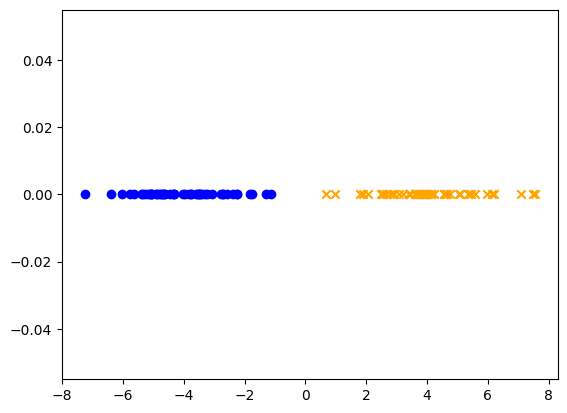

In [198]:
plot_data(features_1, targets_1)

In [199]:
likelihoods_1 = maximum_likelihood(train_features_1, train_targets_1, test_features_1, classes_1)
predictions_1 = predict(likelihoods_1)

In [200]:
print(likelihoods_1)

[[2.10891716e-01 3.44980208e-10]
 [1.86323518e-08 2.70251651e-01]
 [9.53377948e-12 1.82968339e-01]
 [9.45238027e-09 2.75032535e-01]
 [1.08897046e-08 2.74308097e-01]
 [6.46184380e-04 1.78023099e-02]
 [2.88752103e-01 1.30018416e-08]
 [3.37588246e-09 2.76074143e-01]
 [2.49831701e-01 6.15449162e-07]
 [2.88952496e-01 8.84784554e-08]
 [3.32289687e-17 1.42875670e-02]
 [3.31990902e-08 2.63580424e-01]
 [1.87742534e-01 3.54438877e-06]
 [3.68721275e-02 2.74863463e-04]
 [1.05119153e-05 1.07421108e-01]
 [5.02912660e-09 2.76538289e-01]
 [8.01203729e-08 2.48933755e-01]
 [2.64955320e-01 2.86241997e-09]
 [2.86607656e-01 1.09165559e-07]]


In [201]:
calculate_accuracy(predictions_1, test_targets_1)

np.float64(1.0)